# Background

## Get relevant files from web

Instructions for anyone intending to try this notebook:



1.   Download the dataset from https://datadryad.org/stash/dataset/doi:10.5061/dryad.9pf75
2.   Save the zip file to your Google Drive 
3.   Put the filepath below:

In [1]:
dryad_dataset_path = '/content/drive/MyDrive/CS6795_Eye_Tracking/doi_10.5061_dryad.9pf75__v1.zip'

In [2]:
verify_hash = False

# Initial setup

In [3]:
import numpy as np
random_state = 42
np.random.seed(random_state)

In [4]:
import pandas as pd
from PIL import Image
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import shutil
import zipfile
import hashlib


%pip install plotly
import plotly.express as px
import plotly.graph_objs as go

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Clone Git repo

In [5]:
%cd /content/

/content


In [6]:
!git clone https://github.com/szapp/extractFixations

Cloning into 'extractFixations'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Unpacking objects: 100% (16/16), 5.91 KiB | 1.48 MiB/s, done.


##Mount GDrive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Let's extract the relevant files from the dataset.

## Set up dataset locally

### Copy dataset to local directory

Let's copy the dataset to our local directory. After copying, we will verify that the file copied properly using an MD5 hash check.

In [8]:
# new file copy code using shutil.copyfileobj
class TqdmFileWrapper:
    def __init__(self, file, progress_bar, md5=None):
        self.file = file
        self.progress_bar = progress_bar
        self.md5 = md5

    def read(self, size):
        buf = self.file.read(size)
        self.progress_bar.update(len(buf))
        if self.md5 is not None:
            self.md5.update(buf)
        return buf

    def write(self, buf):
        self.file.write(buf)
        self.progress_bar.update(len(buf))

    def close(self):
        self.file.close()

src_path = dryad_dataset_path
dest_path = '/content/dataset.zip'

BLOCK_SIZE = 131072  # 128 KB

src_md5 = hashlib.md5()

# Downloading and verifying the source file
with open(src_path, 'rb') as src_file, open(dest_path, 'wb') as dst_file:
    file_size = os.path.getsize(src_path)
    with tqdm(total=file_size, unit='B', unit_scale=True, desc='Downloading') as pbar:
        wrapped_src_file = TqdmFileWrapper(src_file, pbar, md5=src_md5)
        shutil.copyfileobj(wrapped_src_file, dst_file)

Downloading: 100%|██████████| 7.50G/7.50G [01:09<00:00, 107MB/s]


In [9]:
if verify_hash:
  # Verifying the destination file
  dest_md5 = hashlib.md5()
  with open(dest_path, 'rb') as dst_file:
      file_size = os.path.getsize(dest_path)
      with tqdm(total=file_size, unit='B', unit_scale=True, desc='Verifying') as pbar:
          wrapped_dst_file = TqdmFileWrapper(dst_file, pbar)
          while True:
              buf = wrapped_dst_file.read(BLOCK_SIZE)
              if not buf:
                  break
              dest_md5.update(buf)

  assert src_md5.hexdigest() == dest_md5.hexdigest(), "Hash check FAILED. Source and destination files are NOT IDENTICAL!"

Now, let's unzip the dataset files to a local directory.

In [10]:
src_file = '/content/dataset.zip'
dest_path = '/content/unzipped'

# extract zip to current directory
with zipfile.ZipFile(src_file, 'r') as zip_ref:
    # zip_ref.extractall()
    for zip_info in tqdm(zip_ref.infolist(), desc='Extracting'):
        zip_ref.extract(zip_info, dest_path)

Extracting: 100%|██████████| 48/48 [00:55<00:00,  1.15s/it]


### Extract fixations file: etdb_v1.0.hdf5

In [11]:
source_file = '/content/unzipped/etdb_v1.0.hdf5'
destination_folder = '/content/extractFixations/data/'

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

shutil.copy(source_file, destination_folder) # copy etdb file

'/content/extractFixations/data/etdb_v1.0.hdf5'

### Copy metadata files

#### Extract additional metadata zip 

In [12]:
def extractSubfolderFromZip(source_file, dest_path, subfolder_name, filetype=None):
    print('source_file:', source_file)
    with zipfile.ZipFile(source_file, 'r') as zip_ref:
        for zip_info in tqdm(zip_ref.infolist()):
            # Check if the file/folder starts with the extract folder name
            if zip_info.filename.startswith(f'{subfolder_name}/'):
                # Check if the file is not a directory and has a non-empty filename
                if not zip_info.is_dir() and zip_info.filename:
                    # check if file ends with file extension, if applicable
                    if filetype is None or zip_info.filename.endswith(f'.{filetype}'):
                      # get just the filename & extract to destination
                      zip_info.filename = os.path.basename(zip_info.filename)
                      zip_ref.extract(zip_info, dest_path)

In [13]:
source_file = '/content/unzipped/additional_meta.zip'
destination_folder = '/content/extractFixations/metadata'

if os.path.exists(destination_folder):
    print(f'{destination_folder} already exists! Please remove first.')
else:
    extract_folder_name = "additional_meta"
    extractSubfolderFromZip(source_file, destination_folder, extract_folder_name, 'csv')

source_file: /content/unzipped/additional_meta.zip


100%|██████████| 28/28 [00:00<00:00, 7436.24it/s]


#### Copy meta.csv

In [14]:
source_file = '/content/unzipped/meta.csv'
shutil.copy(source_file, destination_folder) # copy meta.csv file

'/content/extractFixations/metadata/meta.csv'

## Set up image directories locally

The images are stored as zip files in our unpacked dataset directory. Let's extract them to an `imagesets` directory for later reference. 

In [15]:
# create imagesets directory
destination_folder = f'/content/extractFixations/imagesets/'

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

First, let's get a list of the image zip files

In [16]:
source_folder_list = glob.glob('/content/unzipped/Stimuli_*')
source_folder_list.sort()

source_folder_names = [os.path.basename(filename) for filename in source_folder_list]
source_folder_names = [os.path.splitext(filename)[0] for filename in source_folder_names]

print('\n'.join(source_folder_names))

Stimuli_10
Stimuli_11
Stimuli_12
Stimuli_14
Stimuli_15
Stimuli_16
Stimuli_17
Stimuli_18
Stimuli_19
Stimuli_20
Stimuli_21
Stimuli_22
Stimuli_23
Stimuli_24
Stimuli_25
Stimuli_26
Stimuli_27
Stimuli_28
Stimuli_6
Stimuli_7
Stimuli_8


### Extract image directories

Now, let's extract each zip file into a separate subdirectory under `imagesets`.

In [17]:
for source_folder_name in source_folder_names:
  source_file = f'/content/unzipped/{source_folder_name}.zip'
  
  print(f'extracting {source_folder_name}...')

  dest_dir = os.path.join(destination_folder, source_folder_name)

  subfolder_name = source_folder_name.split("_")[1]
  # print(subfolder_name)

  extractSubfolderFromZip(source_file, dest_dir, subfolder_name)

extracting Stimuli_10...
source_file: /content/unzipped/Stimuli_10.zip


100%|██████████| 122/122 [00:00<00:00, 459.82it/s]


extracting Stimuli_11...
source_file: /content/unzipped/Stimuli_11.zip


100%|██████████| 132/132 [00:01<00:00, 118.05it/s]


extracting Stimuli_12...
source_file: /content/unzipped/Stimuli_12.zip


100%|██████████| 582/582 [00:01<00:00, 476.90it/s]


extracting Stimuli_14...
source_file: /content/unzipped/Stimuli_14.zip


100%|██████████| 1206/1206 [00:00<00:00, 1390.32it/s]


extracting Stimuli_15...
source_file: /content/unzipped/Stimuli_15.zip


100%|██████████| 246/246 [00:00<00:00, 584.58it/s]


extracting Stimuli_16...
source_file: /content/unzipped/Stimuli_16.zip


100%|██████████| 66/66 [00:00<00:00, 85.49it/s]


extracting Stimuli_17...
source_file: /content/unzipped/Stimuli_17.zip


100%|██████████| 246/246 [00:03<00:00, 78.45it/s]


extracting Stimuli_18...
source_file: /content/unzipped/Stimuli_18.zip


100%|██████████| 3846/3846 [00:16<00:00, 237.22it/s]


extracting Stimuli_19...
source_file: /content/unzipped/Stimuli_19.zip


100%|██████████| 533/533 [00:02<00:00, 182.60it/s]


extracting Stimuli_20...
source_file: /content/unzipped/Stimuli_20.zip


100%|██████████| 251/251 [00:03<00:00, 71.37it/s] 


extracting Stimuli_21...
source_file: /content/unzipped/Stimuli_21.zip


100%|██████████| 70/70 [00:00<00:00, 2812.33it/s]


extracting Stimuli_22...
source_file: /content/unzipped/Stimuli_22.zip


100%|██████████| 28/28 [00:00<00:00, 2249.47it/s]


extracting Stimuli_23...
source_file: /content/unzipped/Stimuli_23.zip


100%|██████████| 592/592 [00:03<00:00, 166.89it/s]


extracting Stimuli_24...
source_file: /content/unzipped/Stimuli_24.zip


100%|██████████| 134/134 [00:00<00:00, 303.95it/s]


extracting Stimuli_25...
source_file: /content/unzipped/Stimuli_25.zip


100%|██████████| 134/134 [00:00<00:00, 165.80it/s]


extracting Stimuli_26...
source_file: /content/unzipped/Stimuli_26.zip


100%|██████████| 134/134 [00:00<00:00, 974.74it/s]


extracting Stimuli_27...
source_file: /content/unzipped/Stimuli_27.zip


100%|██████████| 134/134 [00:00<00:00, 1076.81it/s]


extracting Stimuli_28...
source_file: /content/unzipped/Stimuli_28.zip


100%|██████████| 244/244 [00:02<00:00, 120.84it/s]


extracting Stimuli_6...
source_file: /content/unzipped/Stimuli_6.zip


100%|██████████| 186/186 [00:00<00:00, 406.52it/s]


extracting Stimuli_7...
source_file: /content/unzipped/Stimuli_7.zip


100%|██████████| 134/134 [00:00<00:00, 147.93it/s]


extracting Stimuli_8...
source_file: /content/unzipped/Stimuli_8.zip


100%|██████████| 134/134 [00:00<00:00, 145.61it/s]


# Preprocess data

We can now begin preprocessing the data for modeling. 

## Load dataset

First, let's load our dataset into memory

In [18]:
%cd /content/extractFixations

/content/extractFixations


In [19]:
import fixmat

We will loop through each of the provided studies in the dataset and combine them into a single dataframe of fixations.

In [20]:
db_keys = ['3D', 'AFC', 'APP', 'APPC', 'Age study', 'Baseline', 'Bias', 'Cross Modal', 'Cross Modal 2', 'EEG', 'Face Discrim.', 'Face Learning', 'Filtered', 'Gap', 'Head Fixed', 'Memory I', 'Memory II', 'Monocular', 'Patch', 'Scaled', 'Tactile', 'Webtask', 'Webtask @ School']

In [21]:
combined = pd.DataFrame()
categories_dict = {}
max_image_dict = {}
dataset_num_dict = {}
num_rows_should_be = 0

for key in tqdm(db_keys, 'loading fixations'):
# for key in db_keys:
  dataset, meta = fixmat.load('/content/extractFixations/data/etdb_v1.0.hdf5', key)
  num_rows_should_be += meta['# Fix.']
  # print(f'for key {key}: columns={dataset.columns}')
  # print(f"Num fixations in {key}: {meta['# Fix.']}")
  categories_dict[key] = dataset['category'].unique().astype(int)
  max_image_dict[key] = dataset['filenumber'].max()
  dataset_num_dict[key] = dataset['dataset_nr'].unique().tolist()
  dataset = dataset[['SUBJECTINDEX', 'dataset_nr', 'x', 'y', 'start', 'end', 'category', 'filenumber', 'fix', 'trial']]
  # datasets = np.concatenate((datasets, dataset['category'].unique().astype(int)))
  combined = pd.concat([combined, dataset], axis=0, ignore_index=True)

print('dropping duplicates...')
combined = combined.drop_duplicates()

display(combined.shape)
display(num_rows_should_be)
display(categories_dict)
# display(max_image_dict)
# display(dataset_num_dict)


loading fixations: 100%|██████████| 23/23 [00:02<00:00, 10.36it/s]


dropping duplicates...


(2826935, 10)

2730534

{'3D': array([23]),
 'AFC': array([18]),
 'APP': array([12]),
 'APPC': array([12]),
 'Age study': array([ 7, 10, 11,  8]),
 'Baseline': array([11,  8,  7, 10]),
 'Bias': array([10,  8, 11,  7]),
 'Cross Modal': array([19]),
 'Cross Modal 2': array([20]),
 'EEG': array([14]),
 'Face Discrim.': array([21]),
 'Face Learning': array([22]),
 'Filtered': array([24, 25,  8, 27,  7, 26]),
 'Gap': array([7, 8]),
 'Head Fixed': array([                   8,                  -10,                   10,
        -9223372036854775808]),
 'Memory I': array([ 7, 11,  8, 10]),
 'Memory II': array([16]),
 'Monocular': array([15, 17]),
 'Patch': array([18]),
 'Scaled': array([28, 17, 15]),
 'Tactile': array([14, 10,  8, 11,  7]),
 'Webtask': array([6]),
 'Webtask @ School': array([6])}

In [22]:
# Create a set of all categories present in the original dictionary
categories = set()
for dataset_categories in categories_dict.values():
    for category in dataset_categories:
        categories.add(category)

# Create the inverted mapping using a dictionary comprehension
inverted_dict = {}
for category in categories:
    datasets = []
    for dataset, dataset_categories in categories_dict.items():
        if category in dataset_categories:
            datasets.append(dataset)
    inverted_dict[category] = datasets

# replace values in inverted dict with their corresponding dataset number


In [23]:
def key_merge(dicts):
    # First, figure out which keys are present.
    keys = set().union(*dicts)
    # Build a dict with those keys, using a list comprehension to
    # pull the values from the source dicts.
    return {
        k: [d[k] for d in dicts if k in d]
        for k in keys
    }
# def key_merge(dicts):
#     result = {}
#     for d in dicts:
#         for key, value in d.items():
#             result.setdefault(key, []).append(value)
#     return result
key_merge((max_image_dict, dataset_num_dict))

{'AFC': [1919.0, [2.0]],
 'EEG': [600.0, [9.0]],
 'Cross Modal': [135, [16.0]],
 'Scaled': [119.0, [10.0]],
 'Age study': [64.0, [0.0]],
 'Tactile': [600.0, [8.0]],
 'Face Learning': [10, [19.0]],
 'Monocular': [119.0, [12.0]],
 'Memory I': [62.0, [4.0]],
 'Cross Modal 2': [224, [17.0]],
 'Webtask': [89.0, [13.0]],
 'Face Discrim.': [32, [18]],
 'Filtered': [64.0, [21.0]],
 'Patch': [1920.0, [1.0]],
 '3D': [144, [20.0]],
 'APP': [68.0, [6.0]],
 'Bias': [64.0, [11.0]],
 'Memory II': [30.0, [5.0]],
 'Gap': [64.0, [22.0]],
 'APPC': [139.0, [7.0]],
 'Webtask @ School': [99.0, [14.0]],
 'Baseline': [64.0, [3.0]],
 'Head Fixed': [64.0, [15.0]]}

In [24]:
del dataset

In [25]:
display(combined)

,SUBJECTINDEX,dataset_nr,x,y,start,end,category,filenumber,fix,trial
0,1.0,20.0,734.606750,506.097168,613.0,833.0,23.0,56.0,1.0,1.0
1,1.0,20.0,836.577698,231.483704,881.0,1165.0,23.0,56.0,2.0,1.0
2,1.0,20.0,1023.959534,396.422333,1209.0,1609.0,23.0,56.0,3.0,1.0
3,1.0,20.0,703.444031,585.581055,1653.0,2101.0,23.0,56.0,4.0,1.0
4,1.0,20.0,424.584930,657.538452,2145.0,2533.0,23.0,56.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2826930,24.0,14.0,525.896057,528.621033,7311.0,7453.0,6.0,88.0,27.0,52.0
2826931,24.0,14.0,385.524994,540.093384,7483.0,7613.0,6.0,88.0,28.0,52.0
2826932,24.0,14.0,356.427521,590.236694,7633.0,7785.0,6.0,88.0,29.0,52.0
2826933,24.0,14.0,327.603027,587.372192,7801.0,7933.0,6.0,88.0,30.0,52.0


## Load in images

Now, let's loop through each image directory and save it to memory in a dataframe.

We'll ignore any images that cause errors.

In [26]:
def process_images(folder_path):
    exceptions = []
    total_files = sum(entry.is_file() and entry.name.lower().endswith(('.png', '.jpg')) for entry in os.scandir(folder_path))

    with tqdm(total=total_files, desc=f'Processing {folder_name}', position=0, leave=True) as progress_bar:
        for entry in os.scandir(folder_path):
            if entry.is_file() and entry.name.lower().endswith(('.png', '.jpg')):
                image_num = entry.name.split('.')[0]

                try:
                    image = Image.open(entry.path)
                    image_arr = np.array(image)
                except:
                    exceptions.append(entry.name)
                    # print(f"\nException! File: {entry.name}")
                    continue

                progress_bar.update(1)
                yield (image_arr, folder_number, image_num)

    if len(exceptions) > 0:
        print('\tFiles with exceptions:', exceptions)


imageset_folder = f'/content/extractFixations/imagesets/'
image_data = []

for folder_name in source_folder_names:
    folder_path = os.path.join(imageset_folder, folder_name)
    folder_number = folder_name.split('_')[1]
    
    # print(f'Processing: {folder_name}')
    image_data.extend(process_images(folder_path))

images_df = pd.DataFrame.from_records(image_data, columns=['image', 'folder_number', 'image_number'])

Processing Stimuli_14: 100%|█████████▉| 598/600 [00:15<00:00, 39.70it/s]


	Files with exceptions: ['196.jpg', '565.jpg']


Processing Stimuli_8: 100%|██████████| 64/64 [00:03<00:00, 16.36it/s]


In [27]:
display(images_df.head())

,image,folder_number,image_number
0,"[[[86, 98, 187], [86, 99, 187], [86, 100, 187]...",10,9
1,"[[[136, 61, 151], [196, 156, 212], [222, 208, ...",10,33
2,"[[[20, 59, 127], [20, 59, 128], [21, 59, 129],...",10,57
3,"[[[235, 29, 35], [236, 30, 35], [238, 39, 34],...",10,54
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",10,7


In [28]:
# images_df.to_pickle('/content/images.pkl')
# print(os.path.getsize('/content/images.pkl')/ (1024**3))

In [29]:
images_df.sort_values(by=['folder_number', 'image_number'], inplace=True)

### Remove anomalous images

Let's identify any images with misshaped dimensions and remove them from our dataset.

In [30]:
# images_df[images_df['image'].apply(lambda x: len(x.shape)) != 3]

In [31]:
images_df.shape #shape before

(4156, 3)

In [32]:
# drop misshapen images
misshapen_images = images_df[images_df['image'].apply(lambda x: len(x.shape)) != 3].index

images_df.drop(misshapen_images, inplace=True)

In [33]:
images_df.shape #shape after

(4045, 3)

### Convert folder/image numbers to ints

Let's convert the folder numbers / image numbers to ints

In [34]:
images_df['folder_number'] = images_df['folder_number'].astype(int)
assert images_df['folder_number'].dtype == 'int64', 'Some folder numbers could not be converted to integers'

In [35]:
images_df['image_number'] = images_df['image_number'].astype(int)
assert images_df['image_number'].dtype == 'int64', 'Some image numbers could not be converted to integers'


## Get initial fixation for each image (match images to fixations)

Now, we will get the corresponding first fixation (of a random subject) for each image. We can add this to our `images_df` dataframe to create a main table matching images to their initial fixations.

In [36]:
# Function to get a random subject's initial fixation for an image
def get_first_fixations_for_image(dataset_number, image_number):
    # get all fixations for current dataset number (category) & image number
    image_fixations = combined[(combined['category'] == float(dataset_number)) & (combined['filenumber'] == float(image_number))]
    if len(image_fixations) == 0:
        # No fixation data for this image; return empty x,y coords
        return pd.Series({'first_x_fixation': np.nan, 'first_y_fixation': np.nan})
    else:
        # Get first fixation for each subject
        first_idx = image_fixations.groupby('SUBJECTINDEX')['start'].idxmin()
        first_fixations = image_fixations.loc[first_idx]
        # image_fixations.sort_values(by=['start', 'end', 'SUBJECTINDEX'], inplace=True)
        # image_fixations = image_fixations.groupby('SUBJECTINDEX').first()

        # for now, return random row from fixations
        first_fixation = image_fixations.sample(random_state=random_state).iloc[0]

        return pd.Series({'first_x_fixation': first_fixation['x'], 'first_y_fixation': first_fixation['y']})

# Adds first fixation's x,y values to every image in images_df
images_df = images_df.assign(**images_df.apply(lambda row: get_first_fixations_for_image(row['folder_number'], row['image_number']), axis=1))

### missed matches EDA (temporary)

In [37]:
# Get 10 random images from the dataset and display them
sample_images = images_df.sample(n=10, random_state=random_state)
print(sample_images[['folder_number', 'image_number', 'first_x_fixation', 'first_y_fixation']])

      folder_number  image_number  first_x_fixation  first_y_fixation
3738             26             6        410.733093        832.291870
396              12            10       1487.665894        854.822571
1836             18           483        364.292267        415.947235
2219             18            48        339.944550        187.007080
3235             19            88        873.826294        134.836761
1280             18          1583        520.983276        373.677216
2430             18          1775       1072.202515        229.139893
2373             18           817        251.902603        439.261932
1041             15            44        923.068909        756.396484
1150             16             8        793.767578       1050.513916


There are a few images that couldn't be matched to initial fixations. \
Let's see how many:

In [38]:
# Count the number of NaN values in the first_x_fixation and first_y_fixation columns
num_nan_x = images_df['first_x_fixation'].isna().sum()
num_nan_y = images_df['first_y_fixation'].isna().sum()

print(f"Number of NaN values in first_x_fixation: {num_nan_x}")
print(f"Number of NaN values in first_y_fixation: {num_nan_y}")

Number of NaN values in first_x_fixation: 144
Number of NaN values in first_y_fixation: 144


In [39]:
num_valid_images = images_df.shape[0] - num_nan_x
pct_valid_images = num_valid_images / images_df.shape[0] * 100.0
print(f'Number of valid images: {num_valid_images} (~{pct_valid_images:0.2f}%)')

Number of valid images: 3901 (~96.44%)


Let's look at which rows have NaN fixations.

In [40]:
nan_images = images_df[(images_df['first_x_fixation'].isna()) | (images_df['first_y_fixation'].isna())]

In [41]:
nan_images['folder_number'].unique()

array([12, 25, 27])

In [42]:
nan_images[nan_images['folder_number'] != 12]

,image,folder_number,image_number,first_x_fixation,first_y_fixation
3628,"[[[150, 148, 154], [148, 148, 152], [152, 154,...",25,57,NaN,NaN
3649,"[[[172, 143, 108], [170, 145, 124], [177, 150,...",25,58,NaN,NaN
3653,"[[[131, 124, 131], [141, 136, 143], [115, 117,...",25,59,NaN,NaN
3657,"[[[101, 110, 106], [101, 113, 108], [88, 104, ...",25,60,NaN,NaN
3663,"[[[113, 112, 100], [110, 106, 93], [128, 119, ...",25,61,NaN,NaN
3654,"[[[127, 155, 159], [124, 151, 159], [121, 148,...",25,62,NaN,NaN
3645,"[[[156, 106, 124], [220, 205, 207], [222, 219,...",25,63,NaN,NaN
3656,"[[[220, 211, 192], [218, 208, 190], [215, 207,...",25,64,NaN,NaN
3756,"[[[77, 85, 87], [77, 85, 87], [76, 84, 86], [7...",27,57,NaN,NaN
3777,"[[[123, 110, 80], [123, 110, 79], [123, 110, 7...",27,58,NaN,NaN


Now, let's make a dataframe with just the images that have matching fixations.

In [43]:
images_df = images_df.dropna(subset=['first_x_fixation', 'first_y_fixation'])
display(images_df.shape)

(3901, 5)

## Export image-fixation dataframe to pkl (locally)

In [44]:
image_fixation_filepath = '/content/images_noNaN_v2.pkl'

images_df.to_pickle(image_fixation_filepath)

print(os.path.getsize(image_fixation_filepath)/ (1024**3))

16.455800927244127


## Save pkl to Google Drive

In [45]:
file_path = image_fixation_filepath
drive_path = "/content/drive/MyDrive/images_noNaN_v2.pkl"

import os
if os.path.exists(drive_path):
    os.remove(drive_path)
# shutil.copyfile(file_path, drive_path)

# Visualizations

Let's see what our data looks like:

## Initial fixation heatmap

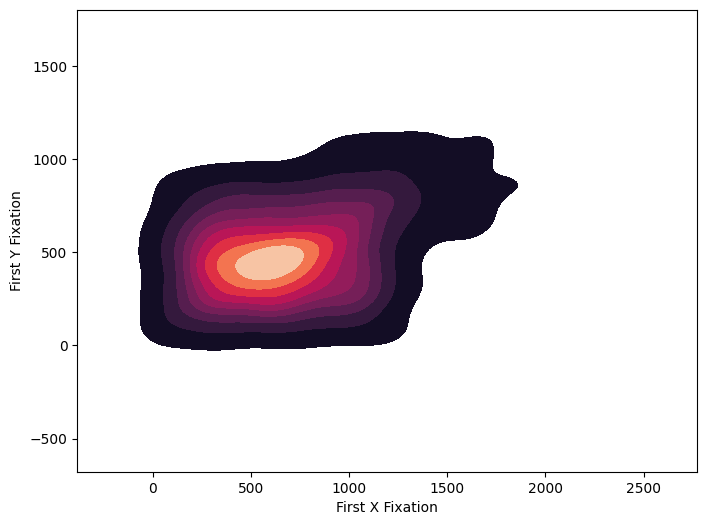

In [46]:
plt.figure(figsize=(8, 6))

sns.kdeplot(
    data=images_df,
    x="first_x_fixation",
    y="first_y_fixation",
    fill=True,
    cmap="rocket",
    thresh=0.05,
)


plt.xlabel("First X Fixation")
plt.ylabel("First Y Fixation")

plt.show()

## Distrib of dataset number

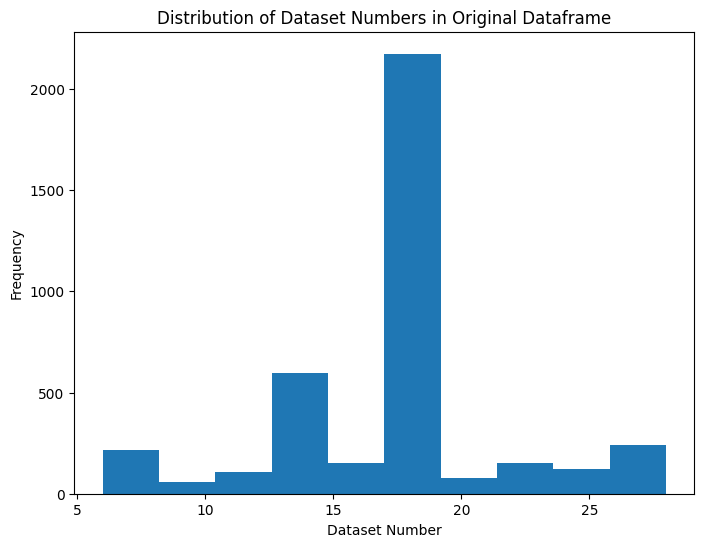

In [47]:
plt.figure(figsize=(8, 6))

plt.hist(images_df['folder_number'])

plt.xlabel('Dataset Number')
plt.ylabel('Frequency')

plt.title('Distribution of Dataset Numbers in Original Dataframe')

plt.show()

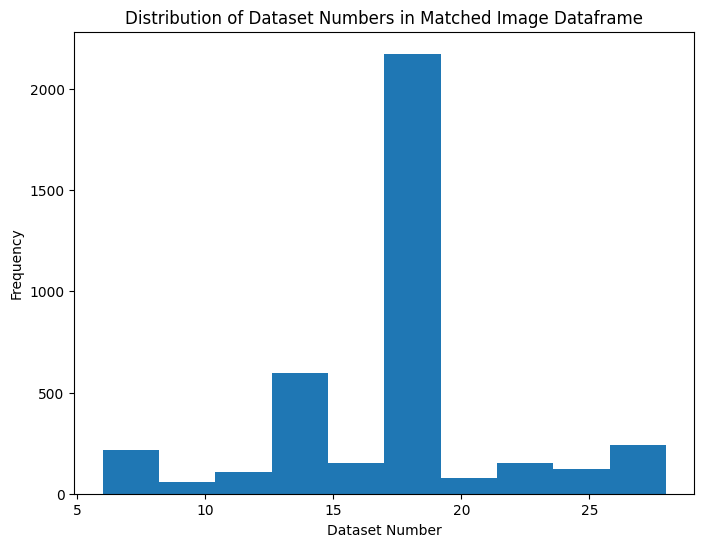

In [48]:
plt.figure(figsize=(8, 6))

plt.hist(images_df['folder_number'])

plt.xlabel('Dataset Number')
plt.ylabel('Frequency')

plt.title('Distribution of Dataset Numbers in Matched Image Dataframe')

plt.show()